## Install Libraries

In [ ]:
%pip install contractions emoji nltk num2words numpy pandas pyspellchecker textacy yellowbrick termcolor gensim

## import libraries

In [345]:
# data science
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from yellowbrick.text import TSNEVisualizer

plt.style.use('fivethirtyeight')
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

# nlp
import re
import string

from collections import Counter
from spellchecker import SpellChecker
import contractions
from num2words import num2words
import emoji
import random
from textacy import extract

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer

from gensim.models import Word2Vec

# misc
# progress bar
from tqdm import tqdm
tqdm.pandas()

# color outputs
from termcolor import colored

# warnings
import warnings
warnings.filterwarnings("ignore")

# Typing
from typing import List, Tuple

# !python -m spacy download en_core_web_sm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/benedictneo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/benedictneo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/benedictneo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/benedictneo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## helpers

In [22]:
def plot_top_n(df: pd.DataFrame, column: str, top: int = 10):
    if column not in df.columns:
        return f"column not in data frame {list(df.columns)}"
    return df[column].value_counts()[:top].plot(kind="barh").invert_yaxis()

## read data

data source:  https://www.kaggle.com/competitions/nlp-getting-started

In [23]:
df_train = pd.read_csv('nlp-getting-started/train.csv')
df_test = pd.read_csv('nlp-getting-started/test.csv')

print('train shape = {}'.format(df_train.shape))
print('train memory = {:.3f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test shape = {}'.format(df_test.shape))
print('Test memory = {:.3f} MB'.format(df_test.memory_usage().sum() / 1024**2))

train shape = (7613, 5)
train memory = 0.291 MB
Test shape = (3263, 4)
Test memory = 0.100 MB


In [24]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [410]:
df_train['length'] = df_train['text'].str.len()
df_train['length'].describe().T

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [411]:
df_train.describe(include='O').T

,count,unique,top,freq
keyword,7552,221,fatalities,45
location,5080,3341,USA,104
text,7613,7503,11-Year-Old Boy Charged With Manslaughter of T...,10
clean_text,7613,6894,watch airport get swallowed sandstorm minute,24
keyword_in_context,7613,506,[],7006


In [44]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

In [34]:
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

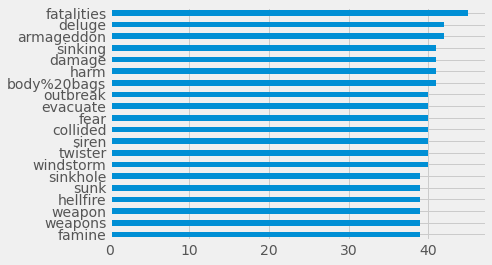

In [54]:
plot_top_n(df_train, 'keyword', 20)

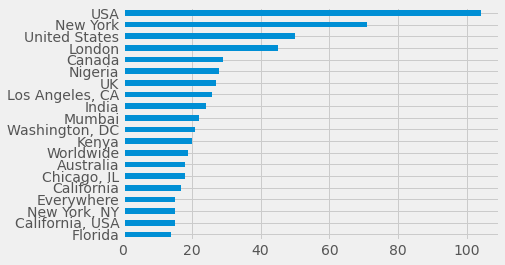

In [55]:
plot_top_n(df_train, 'location', 20)

<AxesSubplot:>

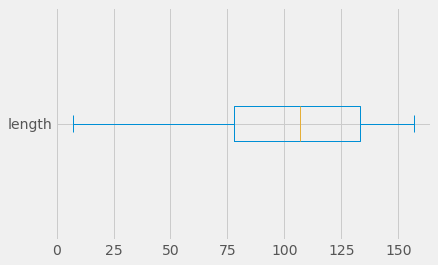

In [56]:
df_train['length'].plot(kind='box', vert=False)

<AxesSubplot:ylabel='Frequency'>

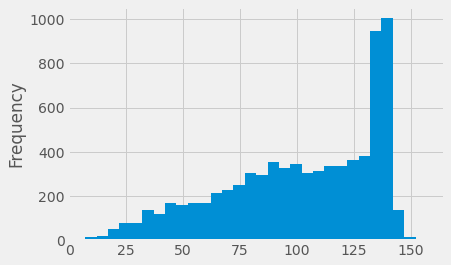

In [57]:
df_train['length'].plot(kind='hist', bins=30)

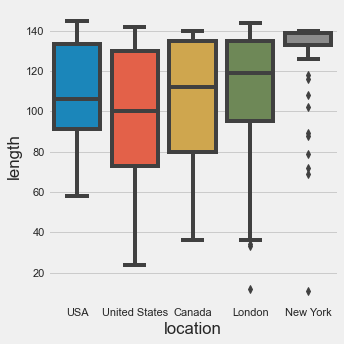

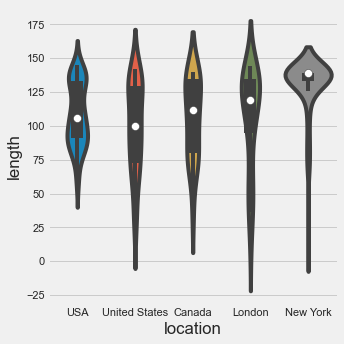

In [76]:
top_5 = df_train["location"].value_counts()[:5].index.tolist()
where = df_train["location"].isin(top_5)

sns.catplot(data=df_train[where], x="location", y="length", kind="box")
sns.catplot(data=df_train[where], x="location", y="length", kind="violin")


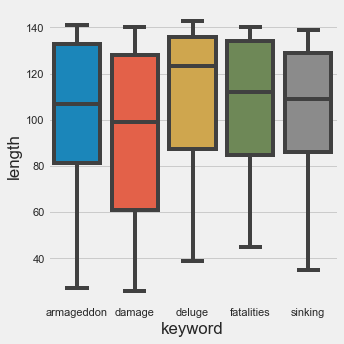

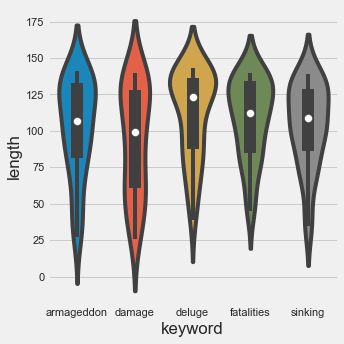

In [77]:
top_5 = df_train["keyword"].value_counts()[:5].index.tolist()
where = df_train["keyword"].isin(top_5)

sns.catplot(data=df_train[where], x="keyword", y="length", kind="box")
sns.catplot(data=df_train[where], x="keyword", y="length", kind="violin")


## text cleaning

### lower case

In [130]:
def lower_case(text: str) -> str:
    return text.lower()

lower_case("HELLO WORLD")

'hello world'

### remove whitespace, linebreaks and tabs

In [129]:
def remove_spaces_tabs(text: str) -> str:
    return " ".join(text.split())

remove_spaces_tabs("hello \n world \t")

'hello world'

### remove punctuation

In [399]:
def remove_punct(text: str) -> str:
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

remove_punct("Hello, world!")

'Hello world'

### remove single characters

In [124]:
def remove_single_char(text: str) -> str:
    return re.sub(r"\b[a-zA-Z]\b", "", text)

remove_single_char("this is a test")

'this is  test'

### remove HTML tags

In [123]:
def remove_html(text: str) -> str:
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

remove_html("Hello <b>World</b>")

'Hello World'

### remove URL

In [122]:
def remove_url(text: str) -> str:
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

remove_url("go to https://www.google.com for answers")

'go to  for answers'

### remove emojis

In [121]:
def remove_emoji(text: str) -> str:
    # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

remove_emoji("Hello 😃")

'Hello '

### emoji to words

In [131]:
def emoji2word(text: str) -> str:
    return " ".join([emoji.demojize(w) if w in emoji.EMOJI_DATA else w for w in text.split()])

emoji2word("Hello 😃")

'Hello :grinning_face_with_big_eyes:'

### remove stopwords

In [393]:
def remove_stopwords(text: str) -> str:
    stop_words = set(stopwords.words("english"))
    stop_words.update(["time"]) # add custom stopwords
    stop_words -= {"no", "not"} # remove custom stopwords
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return " ".join(filtered_sentence)

# stopword sentence example
remove_stopwords("John has not done his homework in time") 

'John not done homework'

### lemmatize

In [136]:
def lemmatize_text_custom(text: str, lemmatizer) -> str:
    wordnet_map = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }

    w_pos_tags = nltk.pos_tag(text.split())
    lemmatized_output = " ".join([lemmatizer.lemmatize(w, wordnet_map.get(pos[0], wordnet.NOUN)) for w, pos in w_pos_tags])
    return lemmatized_output

lemmatizer = WordNetLemmatizer()
lemmatize_text_custom("Lemmatizing removes the affixes of a sentence", lemmatizer)

'Lemmatizing remove the affix of a sentence'

### stemming

In [137]:
def stem_text_custom(text: str, stemmer) -> str:
    word_tokens = word_tokenize(text)
    stemmed_output = " ".join([stemmer.stem(w) for w in word_tokens])
    return stemmed_output

stemmer = PorterStemmer()
stem_text_custom("Stemming removes the affixes of a sentence", stemmer)

'stem remov the affix of a sentenc'

### correct spelling

In [141]:
def correct_spelling(text: str) -> str:
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            # if correction is none return the original word
            if spell.correction(word) is not None:
                corrected_text.append(spell.correction(word))
            else:
                corrected_text.append(word)
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

correct_spelling("spellling is a big probllem")

'spelling is a big problem'

### expand contractions

In [142]:
def expand_contractions(text: str) -> str:
    return contractions.fix(text)

expand_contractions("I'm going to the store")

'I am going to the store'

### digits to words

In [143]:
def convert_digits_to_words(text: str) -> str:
    return " ".join([num2words(w) if w.isdigit() else w for w in text.split()])

convert_digits_to_words("I have 2 dogs")

'I have two dogs'

### put functions into a pipeline

In [415]:
pipeline = [
    lower_case,
    expand_contractions,
    remove_spaces_tabs,
    remove_url,
    remove_punct,
    remove_single_char,
    remove_html,
    remove_stopwords,
    # other functions...
]

def prepare(text, pipeline, lemmatizer=None, stemmer=None):
    tokens = text
    for transform in pipeline:
        # if lemmatize or stem function pass in, perform transformation
        if transform.__name__ == "lemmatize_text_custom":
            tokens = transform(tokens, lemmatizer)
        elif transform.__name__ == "stem_text_custom":
            tokens = transform(tokens, stemmer)
        else:
            tokens = transform(tokens)

    return tokens


df_train["clean_text"] = df_train["text"].progress_apply(prepare, pipeline=pipeline)


100%|██████████| 7613/7613 [00:00<00:00, 7807.59it/s]


In [424]:
print(df_train["text"][7])
print("=>")
print(df_train["clean_text"][7])

I'm on top of the hill and I can see a fire in the woods...
=>
top hill see fire woods


## Visualizations

### ngrams

In [404]:
def get_top_ngrams(text: pd.Series, ngram: int =1, top_n: int =10) -> List[Tuple[str, int]]:
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words="english").fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

get_top_ngrams(df_train["clean_text"])

[('like', 345),
 ('amp', 298),
 ('new', 226),
 ('people', 213),
 ('news', 193),
 ('video', 165),
 ('emergency', 157),
 ('disaster', 153),
 ('going', 147),
 ('police', 141)]

In [281]:
get_top_ngrams(df_train["clean_text"], ngram=2)

[('burning buildings', 60),
 ('suicide bomber', 59),
 ('youtube video', 43),
 ('liked youtube', 42),
 ('northern california', 41),
 ('cross body', 39),
 ('oil spill', 39),
 ('suicide bombing', 34),
 ('california wildfire', 34),
 ('looks like', 33)]

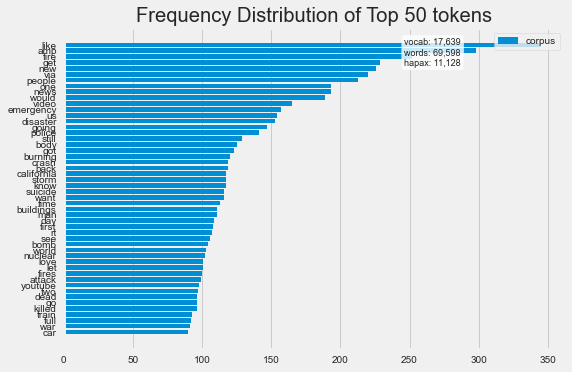

In [276]:
def plot_freq_dist(text: pd.Series) -> None:
    vectorizer = CountVectorizer()
    docs = vectorizer.fit_transform(text)
    features = vectorizer.get_feature_names_out()

    visualizer = FreqDistVisualizer(features=features)
    visualizer.fit(docs)
    visualizer.poof();

plot_freq_dist(df_train["clean_text"])

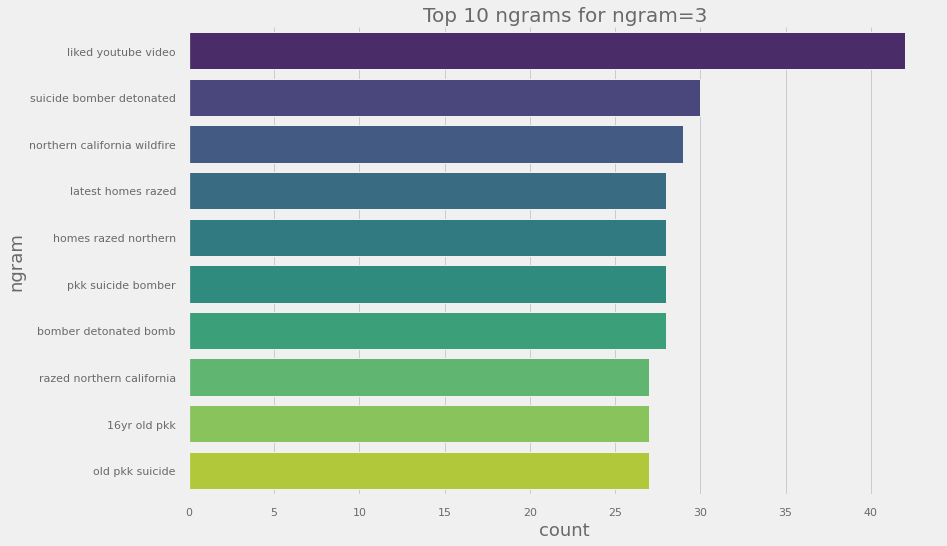

In [409]:
def plot_ngrams_bar(text: pd.Series, ngram: int =1, top_n: int =10) -> None:
    ngrams = get_top_ngrams(text, ngram, top_n)
    df_ngrams = pd.DataFrame(ngrams, columns=["ngram", "count"])
    plt.figure(figsize=(12, 8))
    sns.barplot(x="count", y="ngram", data=df_ngrams, palette="viridis")
    plt.title(f"Top {top_n} ngrams for ngram={ngram}")
    plt.show()

plot_ngrams_bar(df_train["clean_text"], ngram=3)

### word cloud

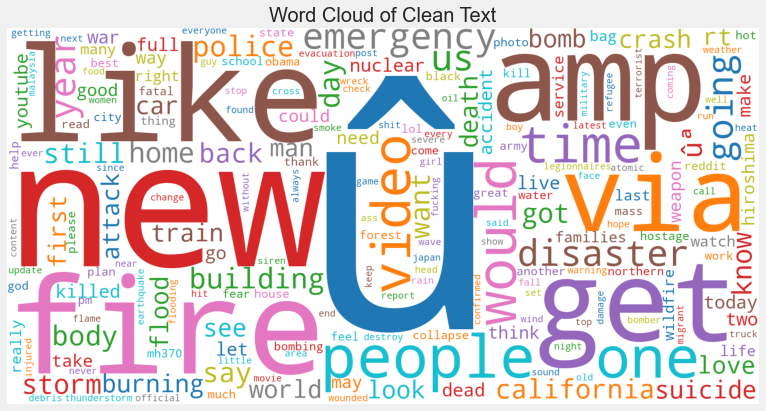

In [289]:
# write a function to plot word cloud with nice colors

STOPWORDS = set(stopwords.words("english"))

def plot_word_cloud(text: pd.Series, title: str =None) -> None:
    wordcloud = WordCloud(
        background_color="white",
        width=1600,
        height=800,
        max_words=200,
        colormap="tab10",
        collocations=False,
        stopwords=STOPWORDS,
    ).generate(" ".join(text))
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    if title:
        plt.title(title, fontsize=20)
    plt.show()

plot_word_cloud(df_train["clean_text"], title="Word Cloud of Clean Text")

### Tsne

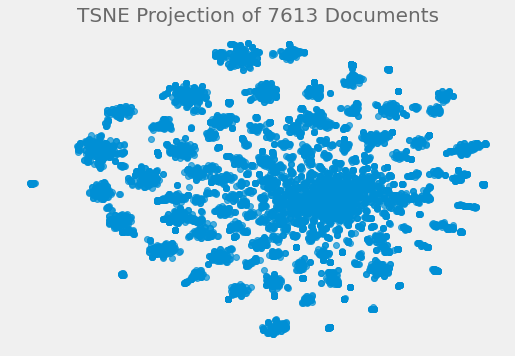

In [398]:
tfidf = TfidfVectorizer()
docs  = tfidf.fit_transform(df_train["clean_text"])

tsne = TSNEVisualizer()
tsne.fit(docs)
tsne.poof();

## Vectorization

### bag of words

In [302]:
cv = CountVectorizer(max_features=1000, ngram_range=(1, 3))
X_train = cv.fit_transform(df_train['clean_text'])

X_train

<7613x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 36281 stored elements in Compressed Sparse Row format>

### tfidf

In [349]:
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 3))
X_train = tfidf.fit_transform(df_train['clean_text'])

X_train

<7613x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 36281 stored elements in Compressed Sparse Row format>

### word2vec

https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec

In [366]:
# tokenize
all_words = [nltk.word_tokenize(sent) for sent in df_train.clean_text]

# train word2vec model
model = Word2Vec(
    all_words,
    min_count=3,  # Ignore words that appear less than this
    vector_size=200,  # Dimensionality of word embeddings
    workers=2,  # Number of processors (parallelisation)
    window=4,  # Context window for words during training
    epochs=30,  # Number of epochs training over corpus
    sg=0, # 1 for skip-gram, 0 for CBOW. (default 0)
)  

In [367]:
len(model.wv.index_to_key)

4291

In [378]:
model.wv.most_similar("destroyed")

[('kaduna', 0.9130124449729919),
 ('rally', 0.8565008640289307),
 ('fed', 0.8532891869544983),
 ('26', 0.8511881232261658),
 ('reportedly', 0.8498510122299194),
 ('houses', 0.8481743931770325),
 ('local\x89û', 0.8379144072532654),
 ('killing', 0.8302043080329895),
 ('17', 0.8278249502182007),
 ('fired', 0.8222361207008362)]

In [376]:
model.wv.most_similar(positive=["fire", "building"])

[('township', 0.9234845638275146),
 ('koin6news', 0.9062016010284424),
 ('street', 0.9058533310890198),
 ('burns', 0.9002577066421509),
 ('catches', 0.8937482237815857),
 ('apartment', 0.8927484154701233),
 ('residential', 0.8915382027626038),
 ('brush', 0.8905351161956787),
 ('manchester', 0.8872421979904175),
 ('several', 0.8804087042808533)]

## keyword search

https://textacy.readthedocs.io/en/stable/api_reference/extract.html#module-textacy.extract.kwic


In [360]:
def search_keyword(text: str, keyword: str) -> List:
    return list(extract.keyword_in_context(text, keyword, window_width=50, ignore_case=True))

def search_keyword_in_df(text: pd.Series, keyword: str, n: int = 10) -> str:

    # apply search keyword function to each row
    kic = text.apply(search_keyword, keyword=keyword)
    
    # filter out empty lists
    kic = kic[kic.apply(len) > 0]

    # check if there are any results
    if len(kic) > 0:
        # check if n is greater than the number of samples
        if len(kic) < n:
            n = len(kic)
        sample_list = kic.sample(n)

        # print results
        for sample in sample_list:
            print(f"{sample[0][0]} {colored(sample[0][1], 'red')} {sample[0][2]}")
    else:
        print(f"No samples found for {colored(keyword, 'red')}")


search_keyword_in_df(df_train['clean_text'], "û")

images famine  û ò hope christ blog happens forget god hopeinchrist
gles war past anniversary devastation wrought the û 
 û ïbbcengland burst water main causes major flooding
architect behind kanye west û ªs volcano
hellfire surrounded desires careful don û ªt let desires control afterlife
 replacement kit emergency dental oral care cosme û 
apollo brown  û ò detonate mop hhbu
t major hurricane past nine years seems like that û 
hobo hobo vintage shira convertible  û  23800 bestseller
ildfire burns california yous china economic net  û 


In [361]:
search_keyword_in_df(df_train['clean_text'], " love ")

rapped leave city supposed normal sports manga wit  love  triangle
aynmalik overwork album going fire overwork stress  love  take care
hey royals  love  damage 2 outs
rt rtrrtcoach  love  truelove romance lith voodoo seduction astrology r
infinitegrace7 screamed world much  love  little pony
slosher goat freaking  love  weapon wait episode splatdown switching splatling 
looks like mudslide tastes like rubber oh  love  bake britishbakeoff paulhollywood
rt ophiuchus2613  love  truelove romance lith voodoo seduction astrology r
opposite  love  fear hereûªs
su fella parsholics superb amp jus soo awesomelove  love  always frvrgrateful


In [362]:
search_keyword_in_df(df_train['clean_text'], " hate ")

tennessee lesbian couple faked  hate  crime destroyed home arsonû lesbian
another fake  hate  crime lesbians burn house else new
love  hate  collided part ii lanjut dirumah yagitudeh jake rum
ears bleeding  hate  stefano
ped massacre send cops house make town permanently  hate  wtf
ûïlordbrathwaite everyone ahh  hate  snow lol call snowstorm growingupincoloradoû
atter head ass people ever actually support causes  hate  black deaths get attention
know  hate  body buy 2 bags chips variety pack fruit snacks re
eshe latinoand ever benothing morebut attack dog 4  hate  group gop
camilla33 craykain  hate  shatter delusions hatchet deadly weapon justifying


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a605a3e6-1564-47b2-94e7-842290ba7692' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>